<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 5
<br>Group member1: Martim Simões
<br>Group member2: Nathan Girard
<br>Group member3: Camil Hamdane
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

# Optional. Conductance/voltage curve

<font size = "3">One way to describe ion channel kinetics is with a conductance/voltage curve. Using data stored in Sigmoid.dat file located in your group folder describing the conductance/voltage relationship for a particular ion channel, find its "best fit" curve using the sigmoid function outlined below:

<font size = "3">The sigmoid function :
\begin{equation}  
    y = \frac {1}{(1 + e^{(\frac{x - vh}{-slope})})}
\end{equation}
    
<font size = "3">Show the data and the fitted curve on the same plot (as it was done in tutorial 1), label the axes with correct units and create a legend to differentiate the data from the fitted curve. At what voltage does this channel reach half its maximal conductance value ? 

# <font color= 'red'>Ex1:</font> Analysing an activation curve.

<font size = "3">Plot each of the traces from the .NWB file in your folder group on one plot and inspect the traces.  Fit each of the traces between a timepoint of your choice (the same for all traces) and the maximum amplitude of the trace to an exponential, to find the time constant at every voltage step. What does this time constant represent ? Plot the time constants for the activation, considering that the clamped voltage stimulation is between -90 and +80 mV with a 10mV step interval. <font color= 'red'>[2 pts]


In [1]:
# Open data with python
import h5py

data_path = 'Group5/Group6/rCell2826.nwb'

data = h5py.File(data_path, 'r')
list(data.keys())

['acquisition',
 'analysis',
 'checksums',
 'epochs',
 'file_create_date',
 'general',
 'identifier',
 'nwb_version',
 'processing',
 'session_description',
 'session_start_time',
 'stimulus']

In [2]:
print(data[('acquisition')].keys())

<KeysViewHDF5 ['images', 'timeseries']>


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def plotDataFiles(nwbFile, protocolName, repID, byTraces = False):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    print(open_data[('/acquisition/timeseries/'+ protocolName + '/repetitions/')].keys())
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    # We can plot the data in two ways:
    # way 1: all the traces in one figure
    if byTraces == False:
        plt.figure()
        plt.title('%s protocol' %protocolName)
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        plt.plot(time, data, 'b')
        plt.show()
    else:
        # way 2: each trace in different figures
        data_t = np.transpose(data)
        i = 0
        for trace in data_t:
            plt.figure()
            plt.title('%s protocol, trace %s' %(protocolName,i))
            plt.ylabel('voltage traces (mV)')
            plt.xlabel('time (ms)')
            plt.plot(time, trace, 'b')
            i = i + 1
        plt.show()  

def fitTraceToExp(nwbFile, protocolName, repID,t_init = 101):
    def fitExp(x,A,tau):
        return A*(1-np.exp(-(x-t_init)/tau));
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    print(open_data[('/acquisition/timeseries/'+ protocolName + '/repetitions/')].keys())
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000;
    time_list = (time.transpose()).tolist()[0];
    #print(time_list)
    ind_t_init = time_list.index(t_init)
    print(ind_t_init)
    data_t = np.transpose(data)
    
    tau_vals = [];
    d_tau_vals = [];
    #Fit each trace
    i = 0
    for trace in data_t:
        trace = trace.tolist()
        trace = trace[ind_t_init:]
        max_value = max(trace)
        max_index = trace.index(max_value)
        #print(max_index)
        trace = trace - trace[0]*np.ones(len(trace)); # ensure each initial value is zero      
        trace = trace[:max_index+1];
        time_t = time_list[ind_t_init:ind_t_init + max_index+1]
        
        plt.figure()
        plt.title('%s protocol, trace %s' %(protocolName,i))
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        plt.plot(time_t, trace, 'b')
        #Fitting
        
        popt, pcov = curve_fit(fitExp, time_t, trace)
        perr = np.sqrt(np.diag(pcov))

        print("A_%i = %f +- %f mV"%(i,popt[0],perr[0]))
        print("τ_%i = %f +- %f ms"%(i,popt[1],perr[1]))
        tau_vals.append(popt[1])
        d_tau_vals.append(perr[1])
        plt.plot(time_t,fitExp(np.array(time_t),popt[0],popt[1]),'r')
        i = i + 1
        plt.show()
    
    #plot values of τ
    '''
    plt.figure()
    plt.errorbar(range(7,7+len(tau_vals[7:])),tau_vals[7:],yerr = d_tau_vals[7:])
    plt.xlabel("trace")
    plt.ylabel("τ(ms)")
    plt.show()
    '''
    return tau_vals,d_tau_vals

<KeysViewHDF5 ['repetition1', 'repetition2', 'repetition3', 'repetition4']>


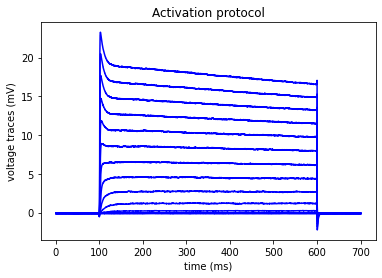

In [4]:
nwbFile = 'Group5/Group6/rCell2826.nwb';
protocolName = "Activation";
repID = '2'
plotDataFiles(nwbFile, protocolName, repID, byTraces = False)   

<KeysViewHDF5 ['repetition1', 'repetition2', 'repetition3', 'repetition4']>
1005
A_0 = 0.007331 +- 0.000120 mV
τ_0 = 97.078170 +- 6.174789 ms


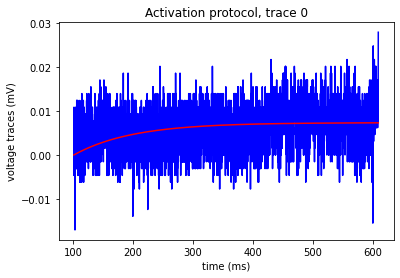

A_1 = -0.000152 +- 0.000072 mV
τ_1 = 4.150230 +- 38.516459 ms


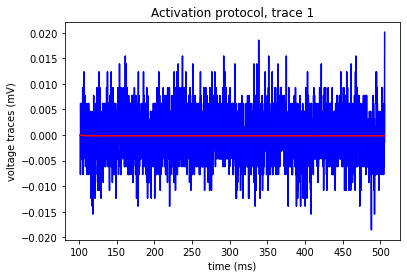

A_2 = -0.004567 +- 0.000104 mV
τ_2 = 0.348388 +- 0.379176 ms


/home/martim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


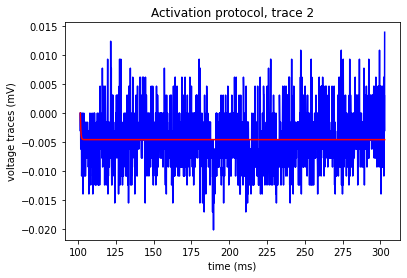

A_3 = 0.003823 +- 0.000075 mV
τ_3 = 0.781085 +- 0.775764 ms


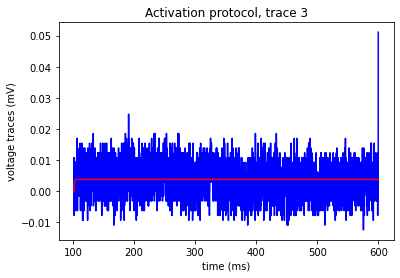

A_4 = -0.014798 +- 0.000076 mV
τ_4 = 2.006991 +- 0.325256 ms


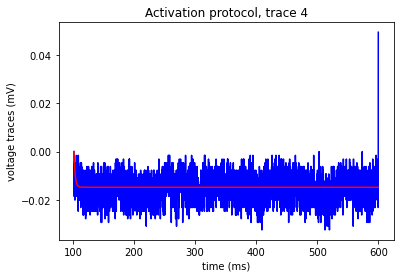

A_5 = -0.001677 +- 0.000066 mV
τ_5 = 0.025729 +- 0.897485 ms


/home/martim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


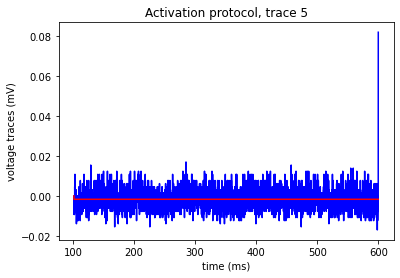

A_6 = 0.019764 +- 0.000116 mV
τ_6 = 34.647999 +- 1.456754 ms


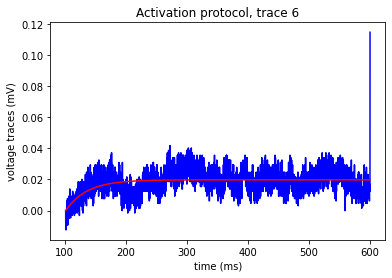

A_7 = 0.285850 +- 0.000178 mV
τ_7 = 24.820490 +- 0.133323 ms


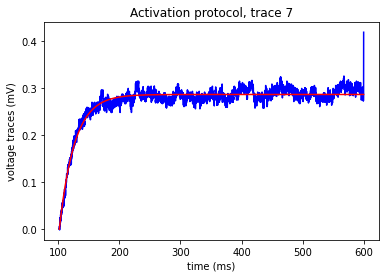

A_8 = 1.218735 +- 0.000324 mV
τ_8 = 16.227247 +- 0.046598 ms


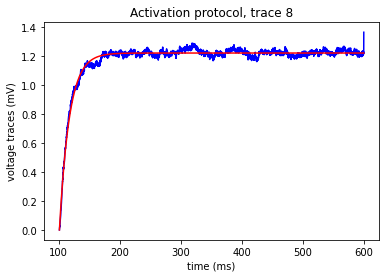

A_9 = 2.698495 +- 0.000596 mV
τ_9 = 8.355451 +- 0.028135 ms


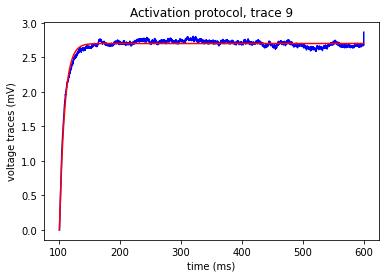

A_10 = 4.370339 +- 0.002761 mV
τ_10 = 3.762777 +- 0.024506 ms


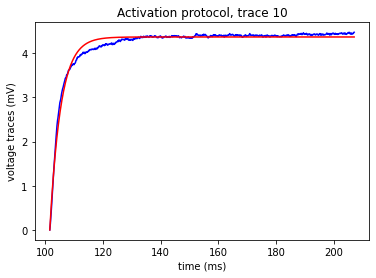

A_11 = 5.746931 +- 0.002259 mV
τ_11 = 1.641533 +- 0.008422 ms


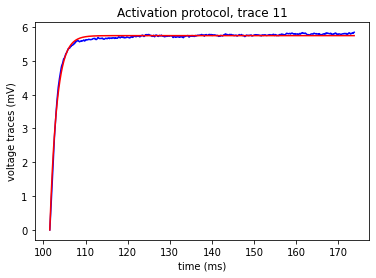

A_12 = 7.005179 +- 0.036948 mV
τ_12 = 0.898938 +- 0.016837 ms


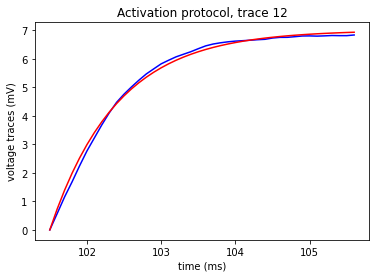

A_13 = 7.138978 +- 0.018244 mV
τ_13 = 0.610770 +- 0.005721 ms


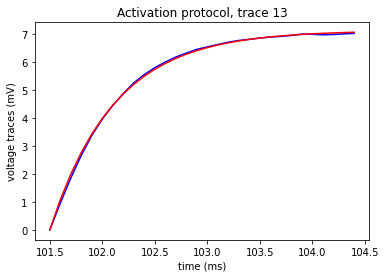

A_14 = 5.810018 +- 0.004863 mV
τ_14 = 0.447407 +- 0.001368 ms


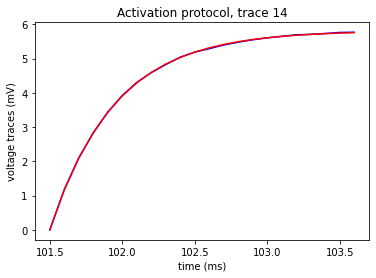

A_15 = 4.158324 +- 0.008811 mV
τ_15 = 0.390597 +- 0.002993 ms


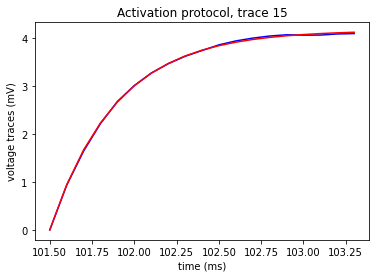

A_16 = 2.787588 +- 0.007486 mV
τ_16 = 0.350893 +- 0.003094 ms


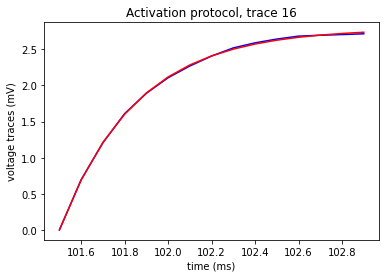

A_17 = 1.831320 +- 0.011741 mV
τ_17 = 0.290570 +- 0.006296 ms


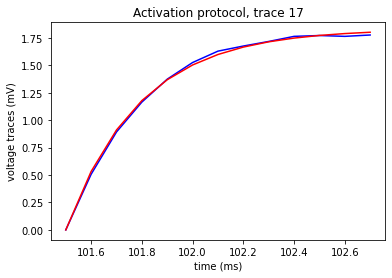

In [5]:
tau, sigma_tau = fitTraceToExp(nwbFile, protocolName, repID,t_init = 101.5)

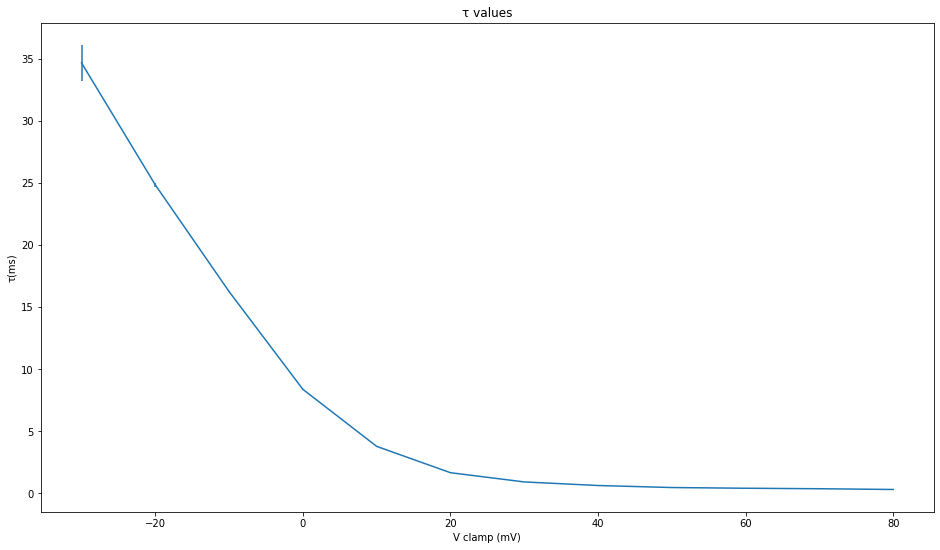

In [6]:
plt.figure(figsize =(16,9))
v_clamp_vals = np.linspace(-90,80,18)
plt.errorbar(v_clamp_vals[6:],tau[6:],yerr = sigma_tau[6:])
plt.title("τ values")
plt.xlabel("V clamp (mV)")
plt.ylabel("τ(ms)")
plt.show()

# <font color= 'red'>Ex2:</font> Finding the rheobase of a cell

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 15 µm of length and diameter, 120 Ω*cm of axial radius and 1.6 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you inject 0.028 pA current into the cell soma with 50 ms delay, 500ms in duration. Use a voltage base of -70 mV and set the total recording duration of the experiment to 800ms. This is your base experiment - plot the injeted currnet and the voltage reponse. Now try to modify the injected current to find the rheobase of this cell - what is its amplitude ? What is the threshold membrane voltage for this cell? 
Now generate a second current clamp experiment where you first inject rheobase current strength into the cell soma with 50 ms delay for 60 ms in duration (stimulus 1) and then a second stimulus with 180 ms delay, half the duration and double the amplitude of simulus 1. What do you observe ? What can you conclude ? Plot the injected current and the voltage response, justify your answer. <font color= 'red'>[1.5 pt]

In [30]:
! nrnivmodl

/home/martim/Desktop/In Silico Neuroscience/Week3_tutorials-20220311
Mod files: "./K_Channel_change_mInf.mod" "./K_Channel_change_Tau.mod" "./K_Channel.mod" "./Na_Channel.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.2' -std=c++11 -shared -fPIC  -I /home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./K_Channel_change_mInf.o ./K_Channel_change_Tau.o ./K_Channel.o ./Na_Channel.o  -L/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/lib   
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.so ./.libs/libnrnmech.so
Successfully created x86_64/special


In [31]:
from neuron import h
import matplotlib.pyplot as plt
%matplotlib inline

h.load_file('stdrun.hoc')

1.0

In [32]:
def simulate_2(I_clamp = 0.028):
    # Create a section 
    soma = h.Section()
    soma.Ra = 120.0   # radius (µm)
    soma.L = 15.0     # length (µm)
    soma.diam = 15.0  # diameter (µm)
    soma.cm = 1.6       # capacitance (µF/cm^2) 
    soma.nseg = 1

    # Insert passive properties
    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # INSERT CHANNEL MODELS
    #Potassium Channel
    soma.insert('K_Ch')
    for seg in soma:
        seg.gKv3bar_K_Ch = 0.01   # Maximal conductance of the potassium channels
    #Sodium Channel
    soma.insert('Na_Ch')
    for seg in soma:
        seg.gNa_Sbar_Na_Ch = 0.09  # Maximal conductance of the sodium channels


    # Inject a current step into the soma
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 50   # stim delay (ms)
    stim.amp = I_clamp    # stim amplitude (pA)
    stim.dur = 500     # stim duration (ms)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)

    # Na current
    rec_iNa = h.Vector()
    rec_iNa.record(soma(0.5)._ref_ina)
    # K current
    rec_iK = h.Vector()
    rec_iK.record(soma(0.5)._ref_ik)

    # Initialize and run a simulation
    h.finitialize(-70)    # initial voltage 
    h.continuerun(800)    # total recording duration

    # PLOT
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title('cell with Na and K channel models')
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_v, 'b')

    plt.subplot(132)
    plt.title('current thourgh K channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iK, 'g')

    plt.subplot(133)
    plt.title('current thourgh Na channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iNa, 'r');
    
    
    plt.suptitle("I clamp {}pA".format(I_clamp))
    return

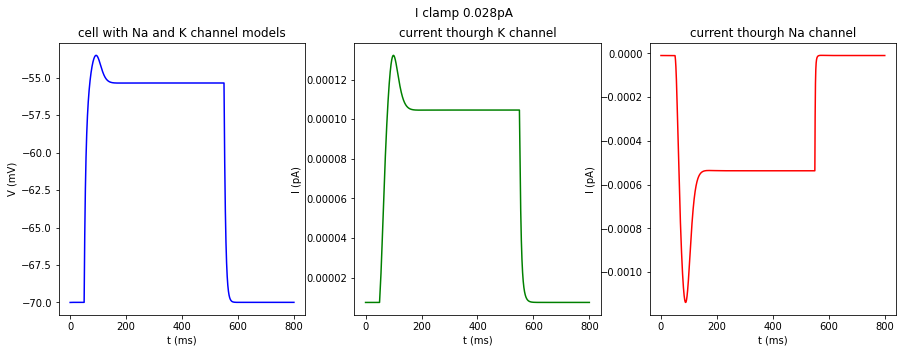

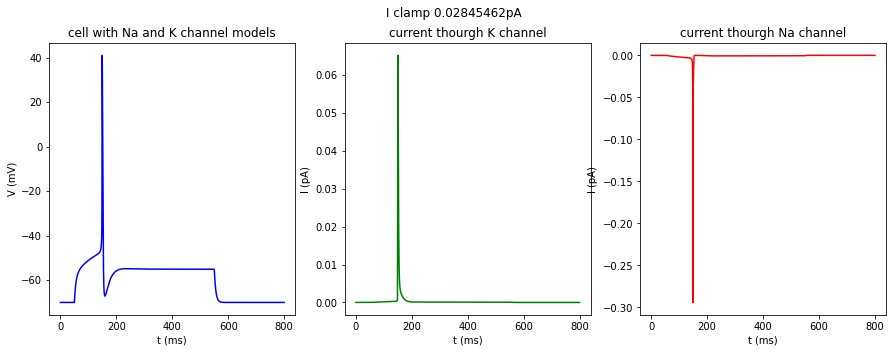

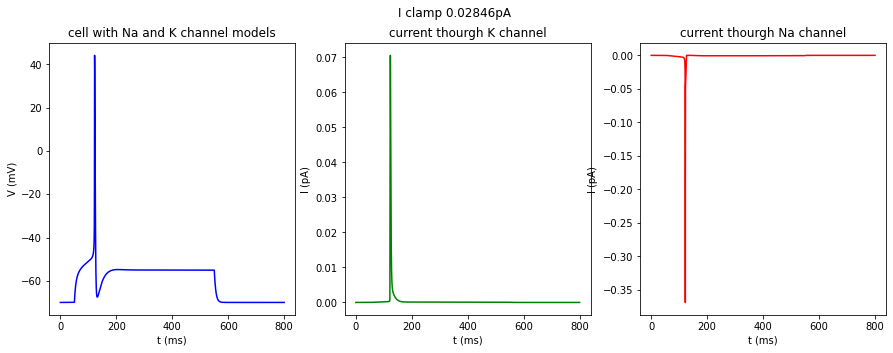

In [33]:
simulate_2();
#simulate_2(0.0284);
#simulate_2(0.02845);
simulate_2(0.02845462);
simulate_2(0.02846);

\begin{equation}
    I_{rheobase} = 0.028455 \pm 0.00005 pA
\end{equation}

\begin{equation}
    V_{threshold} = -50 mV
\end{equation}

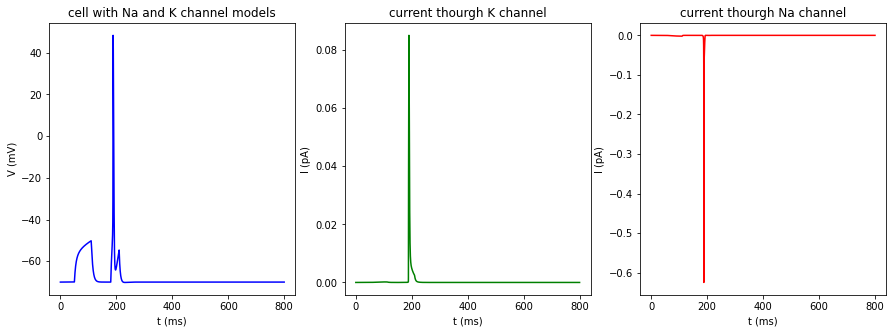

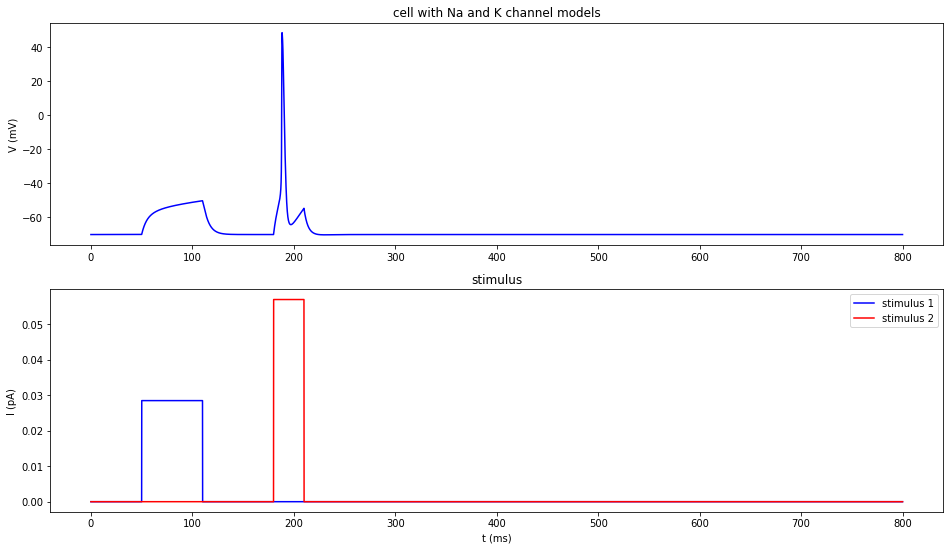

In [34]:
I_rheo = 0.02845462;
# Create a section 
soma = h.Section()
soma.Ra = 120.0   # radius (µm)
soma.L = 15.0     # length (µm)
soma.diam = 15.0  # diameter (µm)
soma.cm = 1.6       # capacitance (µF/cm^2) 
soma.nseg = 1

# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# INSERT CHANNEL MODELS
#Potassium Channel
soma.insert('K_Ch')
for seg in soma:
    seg.gKv3bar_K_Ch = 0.01   # Maximal conductance of the potassium channels
#Sodium Channel
soma.insert('Na_Ch')
for seg in soma:
    seg.gNa_Sbar_Na_Ch = 0.09  # Maximal conductance of the sodium channels


# Inject a current step into the soma
stim1 = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim1.delay = 50   # stim delay (ms)
stim1.amp =  I_rheo   # stim amplitude (pA)
stim1.dur = 60     # stim duration (ms)

stim2 = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim2.delay = 180   # stim delay (ms)
stim2.amp =  2*I_rheo   # stim amplitude (pA)
stim2.dur = 30     # stim duration (ms)

# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)

# current
rec_i1 = h.Vector()
rec_i1.record(stim1._ref_i)
rec_i2 = h.Vector()
rec_i2.record(stim2._ref_i)


# Na current
rec_iNa = h.Vector()
rec_iNa.record(soma(0.5)._ref_ina)
# K current
rec_iK = h.Vector()
rec_iK.record(soma(0.5)._ref_ik)

# Initialize and run a simulation
h.finitialize(-70)    # initial voltage 
h.continuerun(800)    # total recording duration

# PLOT
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('cell with Na and K channel models')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v, 'b')

plt.subplot(132)
plt.title('current thourgh K channel')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_iK, 'g')

plt.subplot(133)
plt.title('current thourgh Na channel')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_iNa, 'r');
    
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.title('cell with Na and K channel models')
plt.ylabel('V (mV)')
#plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v, 'b')
plt.subplot(212)
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i1,'b',label = "stimulus 1");
plt.plot(rec_t,rec_i2,'r',label = "stimulus 2");
plt.legend()
    

# <font color= 'red'>Ex3:</font> Modifing K+ channel kinetics

<font size = "3">Considering the Boltzmann sigmoid function used to represent ion channel dynamics (slide 31 from this week's lecture), explain the meaning of the parameter V1/2. Considering only the dynamics for Na+ and K+ channels in a neuron, illustrate what is the effect of increasing and decreasing the value of V1/2 for the K+ channel. 
To do so, create a cell in Neuron with the following characteristics: 1 section (soma) with one segment, 17.0 µm of length and diameter, 122 Ω*cm of axial radious and 1.2 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you inject a current into the cell soma with 150 ms delay, 600 ms of duration. The total recording duration of the experiment should be 1000 ms and the voltage base -70 mV. 

<font size = "3">Increase and decrase the v_half parameter on the mod file with the K+ channel kinetics. Plot the resulting voltage curves and the I-V and tau-V curves. 
<font size = "3">Explain the meaning of v_half and what you observe. Why does changing this parameter affect the resultant action potential? <font color= 'red'>[2.5 pts]


In [22]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

/home/martim/Desktop/In Silico Neuroscience/Week3_tutorials-20220311
Mod files: "./K_Channel_change_mInf.mod" "./K_Channel_change_Tau.mod" "./K_Channel.mod" "./Na_Channel.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.2' -std=c++11 -shared -fPIC  -I /home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./K_Channel_change_mInf.o ./K_Channel_change_Tau.o ./K_Channel.o ./Na_Channel.o  -L/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/home/martim/anaconda3/lib/python3.7/site-packages/neuron/.data/lib   
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.so ./.libs/libnrnmech.so
Successfully created x86_64/special


In [23]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

h.load_file('stdrun.hoc')

1.0

In [24]:
def simulate_3(I_clamp = 0.028):
    # Create a section 
    soma = h.Section()
    soma.Ra = 122.0   # radius (µm)
    soma.L = 17.0     # length (µm)
    soma.diam = 17.0  # diameter (µm)
    soma.cm = 1.2       # capacitance (µF/cm^2) 
    soma.nseg = 1

    # Insert passive properties
    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # INSERT CHANNEL MODELS
    #Potassium Channel
    soma.insert('K_Ch')
    for seg in soma:
        seg.gKv3bar_K_Ch = 0.01   # Maximal conductance of the potassium channels
    #Sodium Channel
    soma.insert('Na_Ch')
    for seg in soma:
        seg.gNa_Sbar_Na_Ch = 0.09  # Maximal conductance of the sodium channels


    # Inject a current step into the soma
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 150   # stim delay (ms)
    stim.amp = I_clamp    # stim amplitude (pA)
    stim.dur = 600     # stim duration (ms)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # stimulus current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)
    
    # Na current
    rec_iNa = h.Vector()
    rec_iNa.record(soma(0.5)._ref_ina)
    # K current
    rec_iK = h.Vector()
    rec_iK.record(soma(0.5)._ref_ik)

    # Initialize and run a simulation
    h.finitialize(-70)    # initial voltage 
    h.continuerun(1000)    # total recording duration

    # PLOT
    plt.figure(figsize=(15,25))
    plt.subplot(511)
    plt.title('cell with Na and K channel models')
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_v, 'k')

    plt.subplot(512)
    plt.title('current through K channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iK, 'b')

    plt.subplot(513)
    plt.title('current through Na channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iNa, 'b');

    plt.subplot(514)
    plt.title('stimulus current')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_i, 'r')
    
    plt.subplot(515)
    plt.title('IK-V curve')
    plt.xlabel('I (pA)')
    plt.ylabel('v (mV)')
    plt.plot(rec_iK,rec_v, 'k')
    plt.suptitle("I clamp = {}pA , V_1/2 = 18.7mV".format(I_clamp))
    
    print(rec_v[20000])
    print(rec_iK[20000])
    
    return rec_iK,rec_v

def simulate_3mInf(I_clamp = 0.028):
    # Create a section 
    soma = h.Section()
    soma.Ra = 122.0   # radius (µm)
    soma.L = 17.0     # length (µm)
    soma.diam = 17.0  # diameter (µm)
    soma.cm = 1.2       # capacitance (µF/cm^2) 
    soma.nseg = 1

    # Insert passive properties
    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # INSERT CHANNEL MODELS
    #Potassium Channel
    soma.insert('K_Ch_mInf') ######## This channel dynamic desciption is in K_channel_change_mInf.mod
    for seg in soma:
        seg.gKv3bar_K_Ch_mInf = 0.01   # Maximal conductance of the potassium channels

    #Sodium Channel
    soma.insert('Na_Ch')
    for seg in soma:
        seg.gNa_Sbar_Na_Ch = 0.09  # Maximal conductance of the sodium channels


    # Inject a current step into the soma
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 150   # stim delay (ms)
    stim.amp = I_clamp    # stim amplitude (pA)
    stim.dur = 600     # stim duration (ms)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # stimulus current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)
    
    # Na current
    rec_iNa = h.Vector()
    rec_iNa.record(soma(0.5)._ref_ina)
    # K current
    rec_iK = h.Vector()
    rec_iK.record(soma(0.5)._ref_ik)

    # Initialize and run a simulation
    h.finitialize(-70)    # initial voltage 
    h.continuerun(1000)    # total recording duration

    # PLOT
    plt.figure(figsize=(15,25))
    plt.subplot(511)
    plt.title('cell with Na and K channel models')
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_v, 'g')

    plt.subplot(512)
    plt.title('current through K channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iK, 'b')

    plt.subplot(513)
    plt.title('current through Na channel')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_iNa, 'b');

    plt.subplot(514)
    plt.title('stimulus current')
    plt.ylabel('I (pA)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_i, 'r')
    
    plt.subplot(515)
    plt.title('IK-V curve')
    plt.xlabel('I (pA)')
    plt.ylabel('v (mV)')
    plt.plot(rec_iK,rec_v, 'k')
    plt.suptitle("I clamp = {} pA , V_1/2 = 58.7mV".format(I_clamp))
    
    print("time = ",rec_t[20000])
    print("voltage (mV) =",rec_v[20000])
    print("i_K (pA) = ",rec_iK[20000])
    return rec_iK,rec_v

def get_activation_curve(v_half,slope = 9.7):
    I1 = np.arange(0.00001, 1.0, 0.00001)
    V1 = []
    for i1 in I1:
        v1 = v_half- slope*np.log((1/i1)-1)
        V1.append(v1)
    return V1,I1

def eval_activation_curve(v,v_half = 18.7,slope = 9.7):
    return 1/(1+np.exp(-(v-v_half)/slope));

-55.449563869431344
0.00010312818303018444


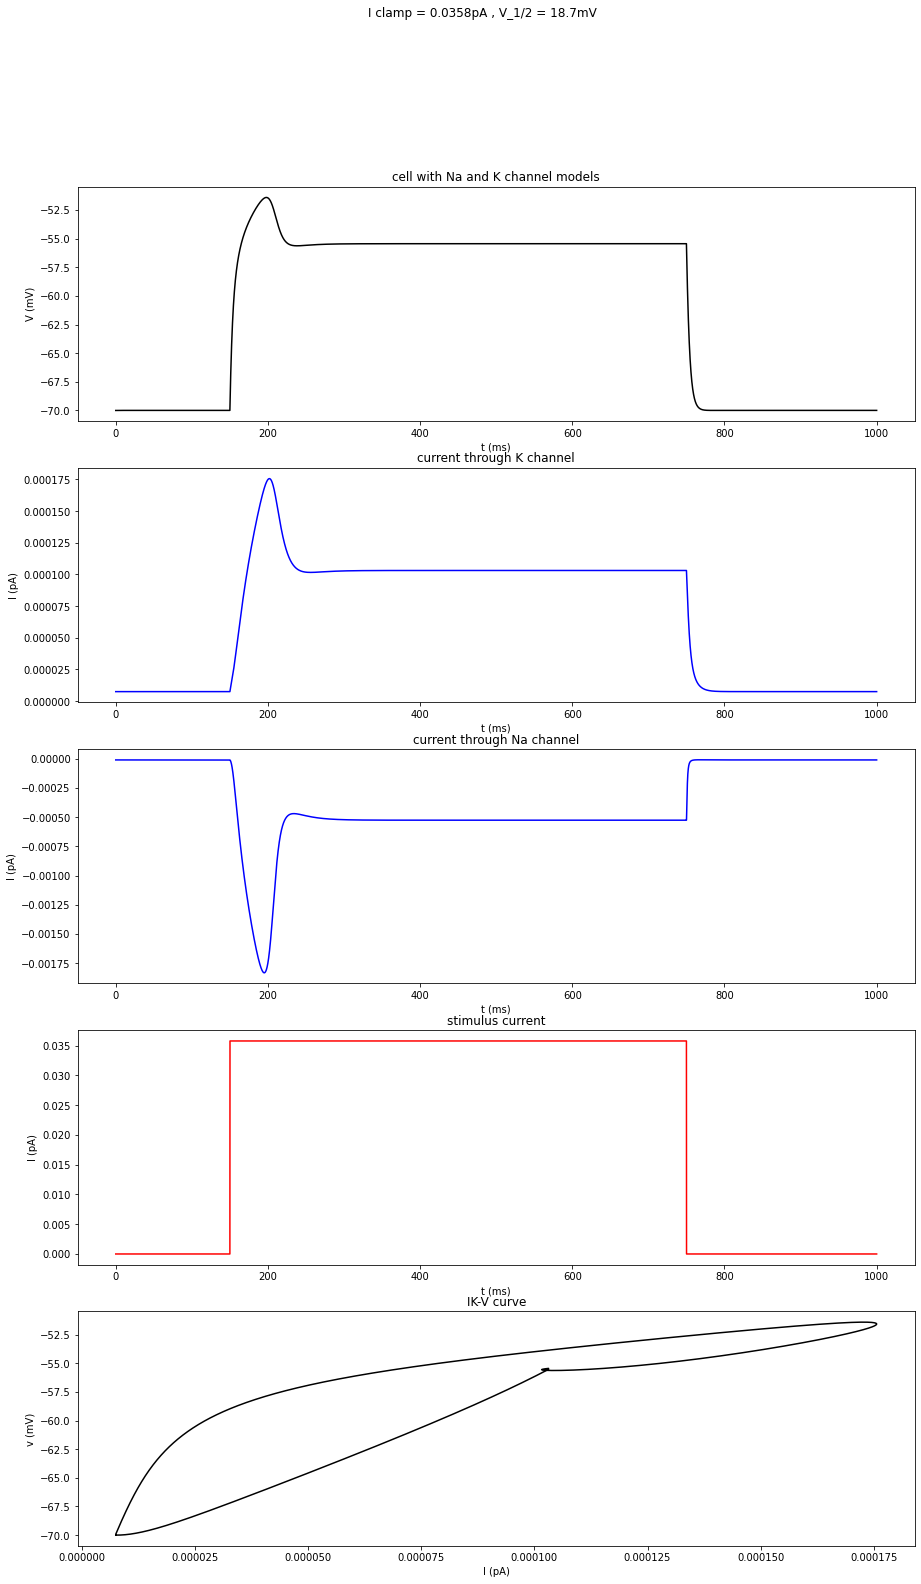

In [25]:
iK,v = simulate_3(0.0358)

time =  499.9999999996822
voltage (mV) = -54.860310143289844
i_K (pA) =  1.82294914884994e-06


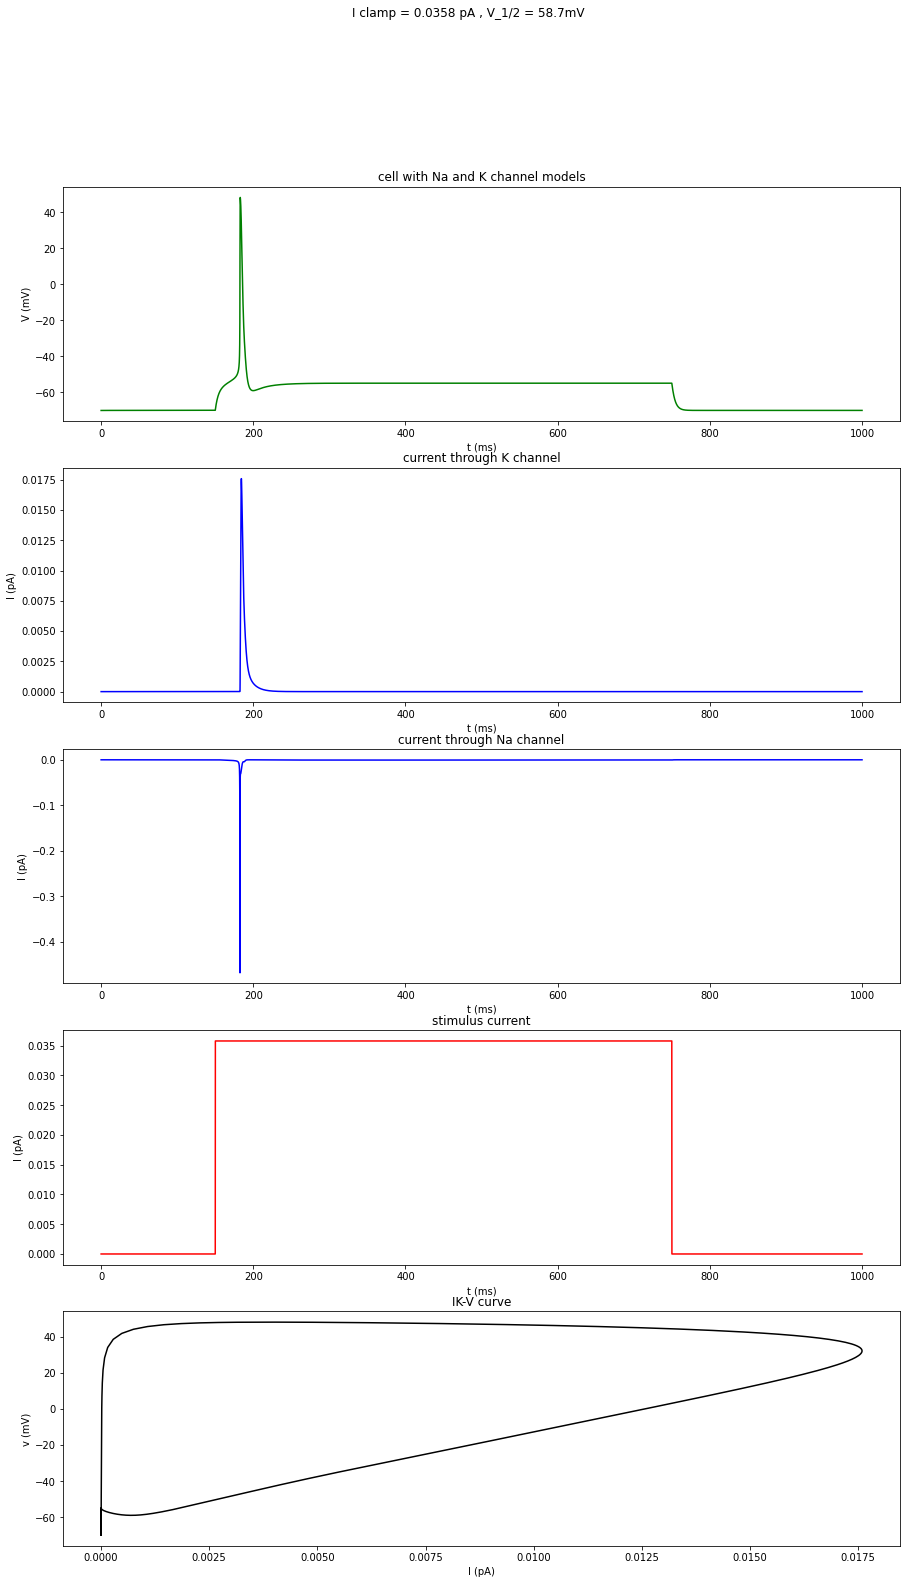

In [26]:
iKmInf, vmInf = simulate_3mInf(0.0358)

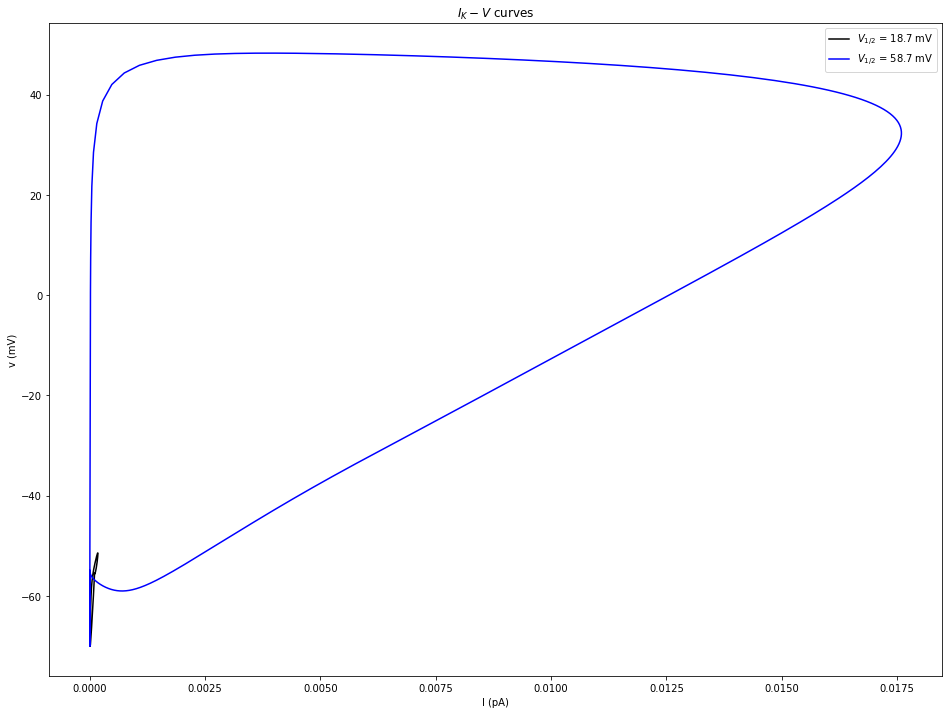

In [29]:
    plt.figure(figsize=(16,12))
    plt.title('$I_K-V$ curves')
    plt.xlabel('I (pA)')
    plt.ylabel('v (mV)')
    plt.plot(iK,v, 'k',label="$V_{1/2}$ = 18.7 mV")
    plt.plot(iKmInf,vmInf, 'b',label="$V_{1/2}$ = 58.7 mV")
    plt.legend()
    plt.show()

In [6]:
#calculate the activation variable of the K channel explicitly at V = -55mV for both values of V_1/2
m_low = eval_activation_curve(-55,18.7)
m_high = eval_activation_curve(-55,58.7)

print("m_low = ",m_low)
print("m_high = ",m_high)



m_low =  0.0005012329960630097
m_high =  8.116126085519643e-06


<font size = "3"> From the previous set of plots we see that the same current clamp experiment produces different results depending on the value of $V_{1/2}$ of the activation curve (mInf) of the potassium channel. With a current of $I_{clamp} = 0.0358 pA$ (close to rheobase) and a value of $V_{1/2} = 18.7 mV$ the neuron does not fire. If $V_{1/2}$ is increased to $V_{1/2} = 58.7 mV$ a spike is observed. $V_{1/2}$ is the value of the membrane potential for which the channel in question is half open (activation variable $m = 1/2$). As the membrane potential is increased, $Na$ chanels are the first open and allow for influx of $Na^+$ ions. This increases the membrane potential further. At a certain point, the $K$ channels open enough for the outflux of positive $K^+$ ions to lower the membrane potential back to the resting voltage. Varying $V_{1/2}$ for the $K$ channel directly varies the voltage at which potassium ions are able to leave the cell and restore the resting potential. For low value of $V_{1/2} = 18.7mV$ , at a voltage $15mV$ above the resting voltage (close to the firing threshold), the potassium channels are more open than for a high value of $V_{1/2} = 58.7$, under similar current clamp conditions (as can be seen by the values $m_{low}$ and $m_{high}$ in the previous cell). This directly implies that the resting potential is restored faster for low values of $V_{1/2}$ and the neuron does not fire. Action potential occurs when the $K$ channels take so long to open that the influx of sodium reaches a runaway regime before the $K$ channels are able to respond.
  
<font size = "5"> NOTE: The value of $V_{1/2}$  in K_Channel_change_mInf.mod was changed to $V_{1/2} = 58.7 mV$ for clarity of distinction

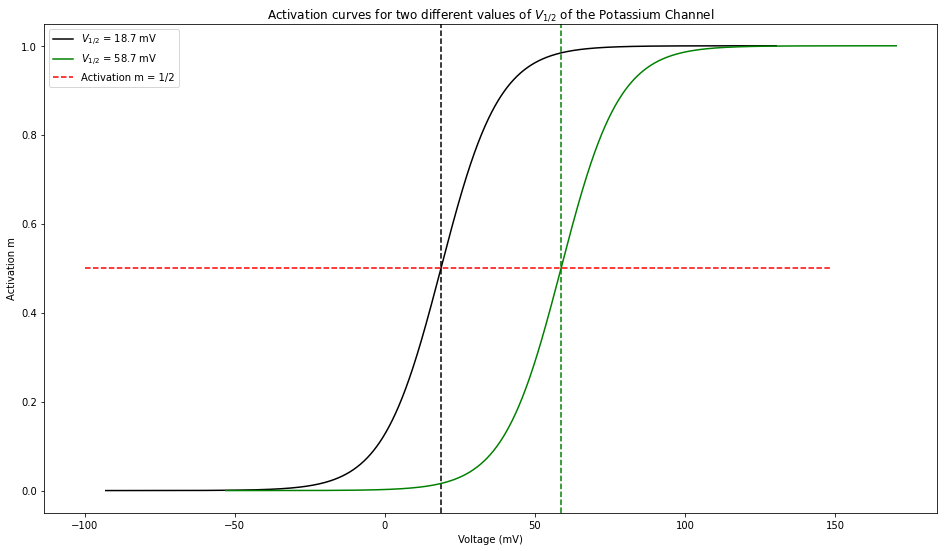

In [8]:
V1, I1 = get_activation_curve(18.7);
V2,_   = get_activation_curve(58.7);

plt.figure(figsize=(16,9))

plt.plot(V1,I1,'k',label="$V_{1/2}$ = 18.7 mV")
plt.axvline(x=18.7,color = 'k',linestyle = '--')

plt.plot(V2,I1,'g',label="$V_{1/2}$ = 58.7 mV")
plt.axvline(x=58.7,color='g',linestyle='--')

Vs =np.arange(-100,150);
plt.plot(Vs,0.5*np.ones(len(Vs)),'--r',label = "Activation m = 1/2")
plt.legend()

plt.xlabel("Voltage (mV)")
plt.ylabel("Activation m")
plt.title("Activation curves for two different values of $V_{1/2}$ of the Potassium Channel")
plt.show()